In [14]:
import keras
from utils import dice_coef,precision, sensitivity,specificity,dice_coef_necrotic,dice_coef_enhancing,dice_coef_edema
import numpy as np
import nibabel as nib
import cv2
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import tensorflow as tf

2023-05-05 15:46:25.039724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model = keras.models.load_model("../models/UnetV4.h5", custom_objects={"dice_coef": dice_coef, "precision":precision, "sensitivity":sensitivity, "specificity":specificity, "dice_coef_necrotic":dice_coef_necrotic,"dice_coef_edema":dice_coef_edema, "dice_coef_enhancing":dice_coef_enhancing })

In [16]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt 

gt1 = np.load("../output/BraTS2021_00000.npy")
gt = nib.load("../smalldata/BraTS2021_00000/BraTS2021_00000_seg.nii.gz").get_fdata()

plt.imshow(gt1[28,:,:,0]*-1)

FileNotFoundError: [Errno 2] No such file or directory: '../output/BraTS2021_00000.npy'

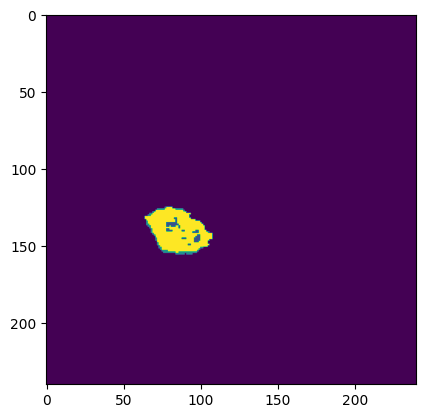

In [12]:
plt.imshow(gt[:,:,55])

In [17]:
IMG_SIZE=128
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 
BATCH_SIZE = 1
TRAIN_DATASET_PATH = "../data/"
SEGMENT_CLASSES = {0 : 'NOT tumor',   1 : 'NECROTIC/CORE', 2 : 'EDEMA',  3 : 'ENHANCING'}

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True, test=False):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.test = test
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, ids):
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        for index, id in enumerate(ids):
            example_path = os.path.join(TRAIN_DATASET_PATH, id)

            flair_image = nib.load(os.path.join(example_path, f'{id}_flair.nii.gz')).get_fdata()    
            ce_image = nib.load(os.path.join(example_path, f'{id}_t1ce.nii.gz')).get_fdata()
            seg_image = nib.load(os.path.join(example_path, f'{id}_seg.nii.gz')).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*index,:,:,0] = cv2.resize(flair_image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*index,:,:,1] = cv2.resize(ce_image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                if(not self.test):
                    y[j +VOLUME_SLICES*index] = seg_image[:,:,j+VOLUME_START_AT]
        
        if(not self.test):
            y[y==4] = 3
            mask = tf.one_hot(y, 4)
            Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
            
        return X/np.max(X), Y


In [18]:
def get_ids(root):
    paths = []
    for name in os.scandir(root):
        paths.append(name.name)
    return paths

ids = get_ids(TRAIN_DATASET_PATH) 

test_gen = DataGenerator([ids[0]], test=False)
print()

In [19]:
preds = model.predict(test_gen)

2023-05-05 15:46:43.785435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 3s 3s/step


In [20]:
eval = model.evaluate(test_gen)

2023-05-05 15:46:49.226004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 4s 4s/step - loss: 0.0038 - accuracy: 0.9986 - mean_io_u_1: 0.3752 - dice_coef: 0.8352 - precision: 0.9983 - sensitivity: 0.9983 - specificity: 0.9994 - dice_coef_necrotic: 0.9083 - dice_coef_edema: 0.9418 - dice_coef_enhancing: 0.9473


In [185]:
eval

[0.0038293597754091024,
 0.9986395239830017,
 0.3752170503139496,
 0.8352073431015015,
 0.9983415603637695,
 0.9982574582099915,
 0.9994456171989441,
 0.9082796573638916,
 0.9418010115623474,
 0.9473382830619812]

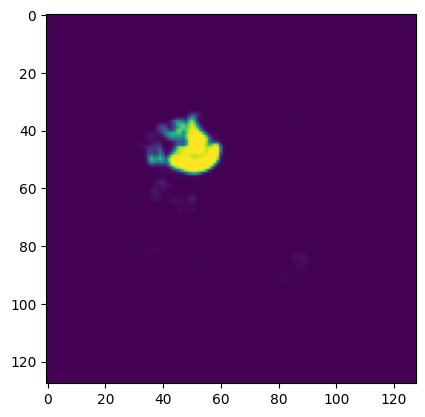

In [21]:
plt.imshow(preds[50,:,:,0] *-1)

In [175]:
ids[0:3]

['BraTS2021_00639', 'BraTS2021_01149', 'BraTS2021_00606']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


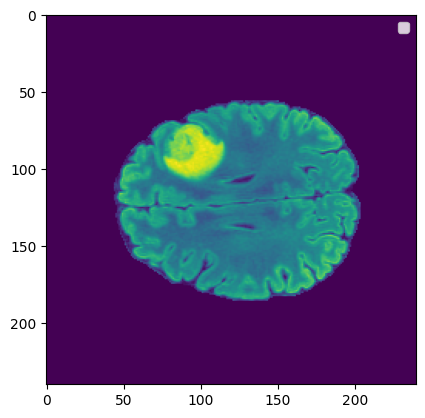

In [126]:
gt = nib.load("../data/BraTS2021_00639/BraTS2021_00639_flair.nii.gz").get_fdata()

gtresized = cv2.resiez(gt, (128,128))
plt.imshow(gt[:,:,77])
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


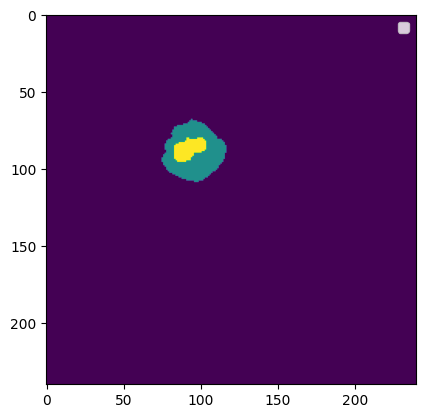

In [170]:
gt = nib.load("../data/BraTS2021_00639/BraTS2021_00639_seg.nii.gz").get_fdata()
plt.imshow(gt[:,:,77])
plt.legend()

In [23]:
mean = (preds[50,:,:,0] *-1).flatten().mean()
std = (preds[50,:,:,0] *-1).flatten().std()

mask = preds[:,:,:,0]*-1 > mean+1*std

In [27]:
mask.shape

(100, 128, 128)

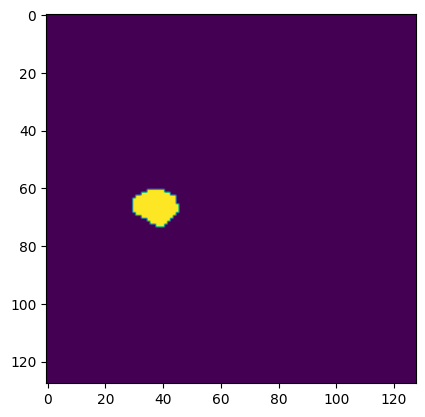

In [77]:
import scipy
import numpy as np

def convex_hull(vol):
    hull_mask = np.zeros(vol.shape)
    for i in range(vol.shape[0]):
        if( np.count_nonzero(vol[i,:,:]) <= 5):
            hull_mask[i,:,:] = vol[i,:,:]
            continue
        arr,_ = flood_fill_hull(vol[i,:,:])
        hull_mask[i,:,:] = arr
    return hull_mask

def flood_fill_hull(image):    
    points = np.transpose(np.where(image))
    hull = scipy.spatial.ConvexHull(points)
    deln = scipy.spatial.Delaunay(points[hull.vertices]) 
    idx = np.stack(np.indices(image.shape), axis = -1)
    out_idx = np.nonzero(deln.find_simplex(idx) + 1)
    out_img = np.zeros(image.shape)
    out_img[out_idx] = 1
    return out_img, hull


def resize_ground_truth(gt):
    y = np.zeros((VOLUME_SLICES, 240, 240))
    Y = np.zeros((VOLUME_SLICES, 128,128, 4))

    for j in range(VOLUME_SLICES):
        y[j] = gt[:,:,j+VOLUME_START_AT]
    
    y[y==4] = 3
    mask = tf.one_hot(y, 4)
    Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    return Y


#augmask,hull = flood_fill_hull(mask[0,:,:])
#len(augmask)
#plt.imshow(augmask)

aug2mask = convex_hull(mask)

plt.imshow(aug2mask[10,:,:])


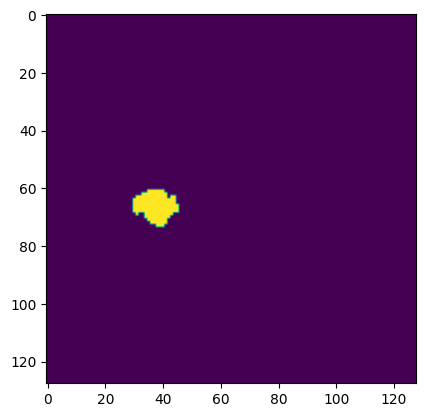

In [68]:
plt.imshow(mask[10,:,:])

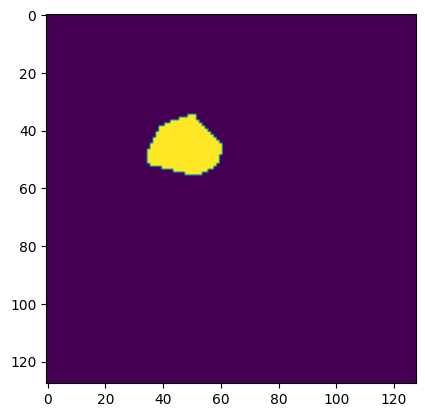

In [212]:
plt.imshow(augmask[0][:,:])

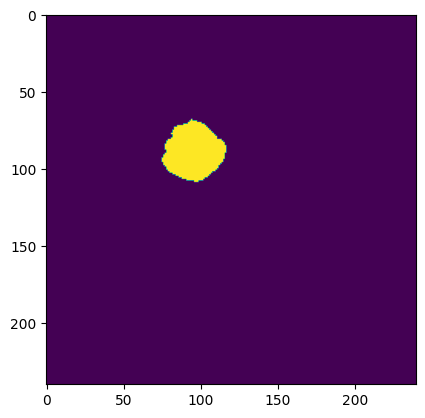

In [205]:
plt.imshow(gt[:,:,77]>0)

In [76]:
from utils import *
dice_coef(gt[:,:,:]>0, mask[50,:,:])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jackklingenberg/C/Brats21/bratsenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5p/6722s8ld0hbcrklmm9nxzcn80000gn/T/ipykernel_1055/912089466.py", line 2, in <module>
    dice_coef(gt[:,:,:]>0, mask[50,:,:])
  File "/Users/jackklingenberg/C/Brats21/src/utils.py", line 54, in dice_coef
IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jackklingenberg/C/Brats21/bratsenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/jackklingenberg/C/Brats21/bratsenv/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1396, in structured_traceback
    return FormattedTB.stru

(240, 240, 155)